<a href="https://colab.research.google.com/github/Jinyong-20/Machine_Learning_Programming/blob/master/lesson1_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


▲ 본인의 드라이브에 마운트한다

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

▲ 내용 변경사항이 생길때 자동으로 리로드

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

▲ fastai.vision라이브러리에 있는 함수들을 모두 임포트
fastai.metrics에서 error_rate함수를 임포트

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

▲ batch size를 64로(한번에 처리하는 크기)

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [6]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



▲ help("이름") : 이름에 대한 정보를 불러온다
함수의 경우, 함수의 인자등의 자료형을 표시해준다.

In [7]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

▲ pets 이미지 url주소

In [8]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

▲ untar_data("주소") - 주소에 있는 데이터들을 이름으로 받아온다

In [10]:
doc(untar_data)

In [11]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

▲ ls() - 저장되어 있는 변수 모두 표시

In [12]:
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

▲ path안의 변수들에 접근할 수 있도록 경로를 새로운 변수들에 저장한다

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [14]:
fnames = get_image_files(path_img)
fnames[:37]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_99.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_74.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_141.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/leonberger_33.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_148.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_53.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/boxer_75.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_10.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_86.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_67.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/boxer_148.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_175.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_159.jpg'),
 PosixPath('/root/.fastai/d

▲ path안의 images에 접근하여 안의 내용을 이미지파일로 받아와 fnames 초기화

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

▲ 난수 설정
정규표현식으로 이름을 pat에 저장

r'/([^/]+)_\d+.jpg$'

[^/] : /를 제외한 모든 것

$ : 끝문자 지정

\d : 숫자

. : 무엇이든 한글자

\+ : 1 or more?



In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

▲ 경로상의 fnames 리스트를 pat를 통해 재표현해서 이미지 데이터 번치 생성

In [18]:
doc(ImageDataBunch.from_name_re)
help(ImageDataBunch.from_name_re)

Help on method from_name_re in module fastai.vision.data:

from_name_re(path:Union[pathlib.Path, str], fnames:Collection[pathlib.Path], pat:str, valid_pct:float=0.2, **kwargs) method of builtins.type instance
    Create from list of `fnames` in `path` with re expression `pat`.



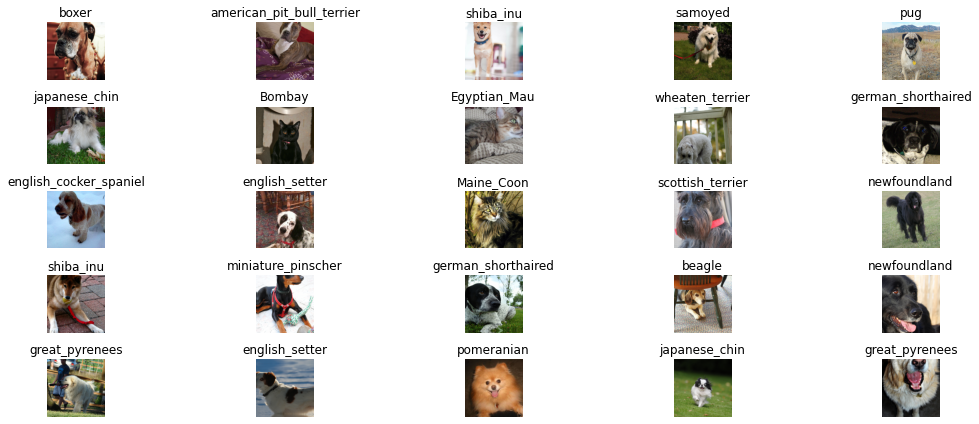

In [19]:
data.show_batch(rows=5, figsize=(15,6))

▲ 데이터를  5x5, 가로 15, 세로 6의 크기로 보여준다

In [20]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

▲ 데이터의 클래스들을 출력하고 클래스들의 길이와 데이터의 클래스 갯수를 출력한다

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


▲ 사전에 학습한 learner를 resnet34를 모델로 해서 받아온다

In [22]:
help(cnn_learner)
doc(cnn_learner)

Help on function cnn_learner in module fastai.vision.learner:

cnn_learner(data:fastai.basic_data.DataBunch, base_arch:Callable, cut:Union[int, Callable]=None, pretrained:bool=True, lin_ftrs:Union[Collection[int], NoneType]=None, ps:Union[float, Collection[float]]=0.5, custom_head:Union[torch.nn.modules.module.Module, NoneType]=None, split_on:Union[Callable, Collection[Collection[torch.nn.modules.module.Module]], NoneType]=None, bn_final:bool=False, init=<function kaiming_normal_ at 0x7fbca76f8f28>, concat_pool:bool=True, **kwargs:Any) -> fastai.basic_train.Learner
    Build convnet style learner.



In [23]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

▲ learner에 있는 model 출력

In [24]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.361448,0.366134,0.121110,01:24
1,0.630767,0.248510,0.082544,01:23
2,0.376052,0.224618,0.075101,01:24
3,0.270385,0.218470,0.071719,01:24


▲ 이미지 구별하기를 4번 반복하여 수행하며 러너가 학습

In [0]:
learn.save('stage-1')

▲ 기존의 학습을 저장

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

▲ 러닝 결과를 해석

최대 손실함수*가장 안좋은 상황 을 찾아냄

In [27]:
interp.top_losses()

torch.return_types.topk(values=tensor([9.2444, 8.8627, 7.0009,  ..., -0.0000, -0.0000, -0.0000]), indices=tensor([1225,  163,  531,  ...,  558,  670, 1475]))

▲ 최대 손실

In [28]:
doc(ClassificationInterpretation)
help(ClassificationInterpretation)

Help on class ClassificationInterpretation in module fastai.train:

class ClassificationInterpretation(Interpretation)
 |  Interpretation methods for classification models.
 |  
 |  Method resolution order:
 |      ClassificationInterpretation
 |      Interpretation
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  GradCAM = _cl_int_gradcam(self, idx, ds_type:fastai.basic_data.DatasetType=<DatasetType.Valid: 2>, heatmap_thresh:int=16, image:bool=True)
 |  
 |  __init__(self, learn:fastai.basic_train.Learner, preds:torch.Tensor, y_true:torch.Tensor, losses:torch.Tensor, ds_type:fastai.basic_data.DatasetType=<DatasetType.Valid: 2>)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  confusion_matrix(self, slice_size:int=1)
 |      Confusion matrix as an `np.ndarray`.
 |  
 |  most_confused(self, min_val:int=1, slice_size:int=1) -> Collection[Tuple[str, str, int]]
 |      Sorted descending list of largest non-diagonal entries of confusion matrix, 

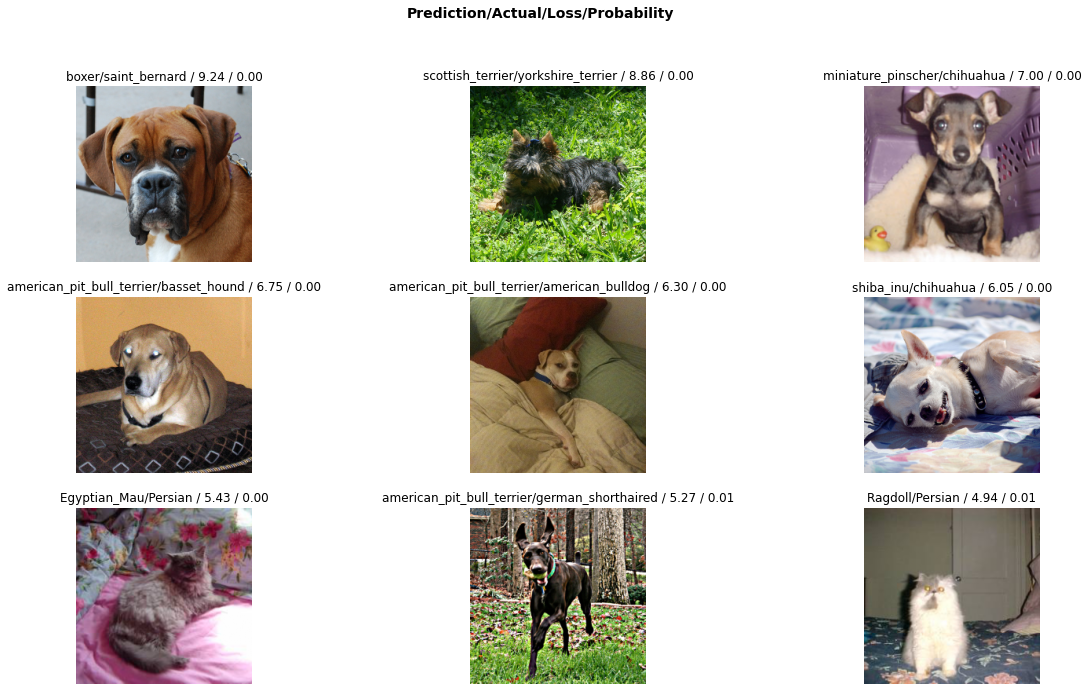

In [29]:
interp.plot_top_losses(9, figsize=(20,11))

▲ 확신에 비해 결과가 제일 나쁜 상황(top_losses)들을 출력 9x9, 가로 20, 세로11
이미지 위의 표현 값들은 각각 추측 / 정답 / 손실 / 실제 가능성

In [30]:
doc(interp.plot_top_losses)

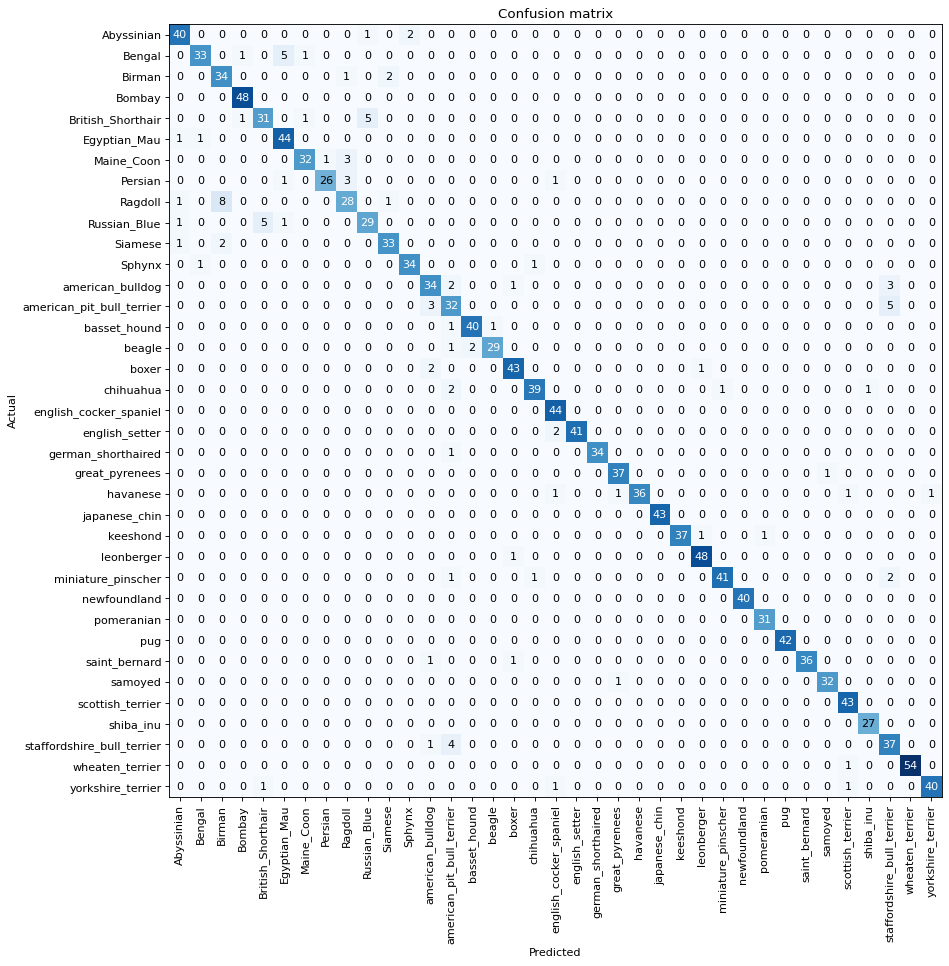

In [31]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=80)

▲ 가장 혼동되는 케이스들을 짙은 색으로 표시해주는 행렬 표현

In [32]:
interp.most_confused(min_val=3)

[('Ragdoll', 'Birman', 8),
 ('Bengal', 'Egyptian_Mau', 5),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Maine_Coon', 'Ragdoll', 3),
 ('Persian', 'Ragdoll', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3)]

▲ 가장 혼동되는 케이스들(최소 3번(min_val의 값)이상 틀린)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

▲ learner를 다시 작동

In [34]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.624469,0.365427,0.117050,01:28


러너의 이미지 구별하기를 1회 수행
 => 기존보다 에러율이 높아진 이유는? 기존 학습학 내용을 불러오지 않았기 때문에 최초 수행과 다르지 않음

In [0]:
learn.load('stage-1');

▲ 기존의 학습내용을 불러옴

In [42]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


▲ 가장 적합한 사례를 찾음

※lr = learning rate / 학습률

 lr_find 메서드는 Leslie N. Smith의 논문인 “Cyclical Learning Rates for Training Neural Networks” 에 나온 방법론을 따랐다. 쉽게 말하면 single mini-batch SGD를 매우 작은 lr에서부터 점점 키워가며 진행하고 그 loss들을 기록해놓은 다음에 loss가 지속해서 감소하는 과정에 있는 lr들 중에서 가장 큰 lr을 찾는 것이다. 직관적으로 봤을 때, loss가 계속 감소한다는 것은 수렴을 향해 간다는 것이고, 그 중에서 가장 큰 lr을 찾는 것은 수렴 속도를 빠르게 하기 위함이다

 [출처] : https://coffeedjimmy.github.io/fastai_mnist_intro/



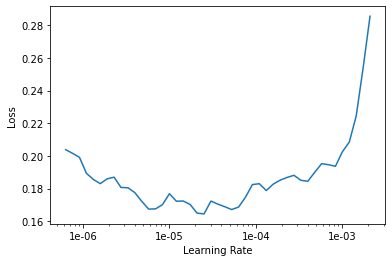

In [43]:
learn.recorder.plot()

▲ 찾은 사례의 손실 비율을 나타내는 그래프

In [44]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.188910,0.198288,0.064276,01:29
1,0.156445,0.189415,0.064953,01:31


▲ 러너를 다시 작동시키고, 학습률 1e-5에서 1e-4의 구간에서 2번 반복 수행

기존보다 오류율이 낮아지고 정확도가 올라감

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//3).normalize(imagenet_stats)

▲ resnet50으로 수행하기 때문에 사이즈를 키우고, batch size를 기존보다 줄여 메모리 사용 과부화를 막는다

In [46]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


▲ 마찬가지로 학습된 러너를 받아옴

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


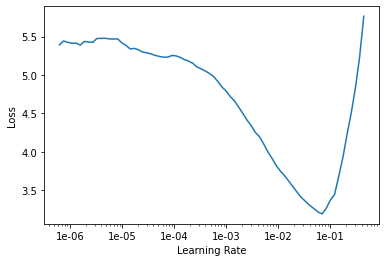

In [47]:
learn.lr_find()
learn.recorder.plot()

▲ 최적의 사례를찾고, 이의 그래프를 출력

In [48]:
doc(lr_find)

In [49]:
learn.fit_one_cycle(9)

epoch,train_loss,valid_loss,error_rate,time
0,0.697574,0.342202,0.109608,02:26
1,0.538818,0.350032,0.098782,02:28
2,0.466660,0.306459,0.084574,02:30
3,0.383993,0.247763,0.072395,02:31
4,0.332439,0.233826,0.063599,02:31
5,0.239727,0.202700,0.061570,02:34
6,0.159399,0.189275,0.058187,02:33
7,0.154004,0.178275,0.053451,02:32
8,0.145313,0.175173,0.049391,02:33


▲ 이미지 구별하기 작업을 9번 반복 수행 및 학습

In [0]:
learn.save('stage-1-50')

▲ 학습결과 저장

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [51]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-3,1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,8.735153,6.302013,0.962788,02:48
1,5.122581,45852.382812,0.966170,02:47
2,3.666470,19809.451172,0.949256,02:46


▲ 학습률 1e-3 ~ 1e-1 범위에서 3번 반복 수행(기존 학습은 불러오지 않았음)

If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

▲ 학습 불러오기

In [53]:
interp = ClassificationInterpretation.from_learner(learn)

▲ 내용 해석

In [54]:
interp.most_confused(min_val=4)

[('Ragdoll', 'Birman', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 4),
 ('miniature_pinscher', 'chihuahua', 4)]

▲ 가장 혼돈되는 경우들(최소 4회 틀린)

## Other data formats

In [55]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/root/.fastai/data/mnist_sample')

▲ 새로운 데이터 경로를 받아옴

In [56]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/mnist_sample/train/3'),
 PosixPath('/root/.fastai/data/mnist_sample/train/7')]

▲ path의 train안에 있는 모든 변수

In [57]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/root/.fastai/data/mnist_sample/valid'),
 PosixPath('/root/.fastai/data/mnist_sample/train')]

▲ path안의 모든 변수

In [59]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)
data

ImageDataBunch;

Train: LabelList (12396 items)
x: ImageList
Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_sample;

Valid: LabelList (2038 items)
x: ImageList
Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26),Image (3, 26, 26)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_sample;

Test: None

▲ 기존 이미지 데이터 번치를 받아오는 과정에서 from_name_re가 아닌 from_folder로 받아옴

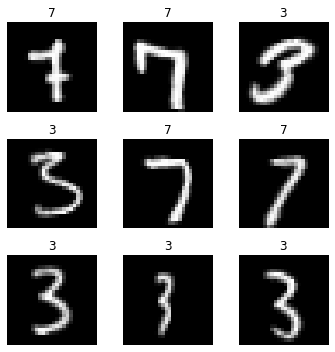

In [60]:
data.show_batch(rows=3, figsize=(5,5))

▲ 데이터를 3x3, 가로 5, 세로5로 출력

In [61]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.205693,0.089722,0.967125,00:18
1,0.115991,0.050782,0.984789,00:18


▲ resnet18을 모델로 학습된 러너를 받아옴, error_rate가 아닌 accuracy로 표현방식 변경

fit_one_cycle()이 아닌 fit으로 작업 수행

In [62]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


▲ 데이터를 csv파일의 형태로 읽을 수 있음(path.ls()에서 나온 csv파일에 접근하여 읽어옴)

In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

▲ 마찬가지로 csv에서 이미지 데이터 번치를 받아올 수도 있음

[0, 1]

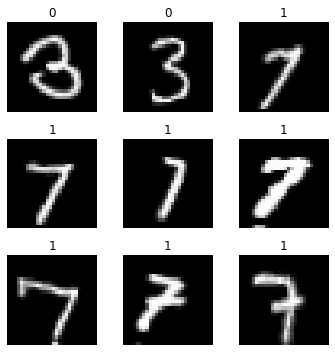

In [64]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

▲ 데이터를 마찬가지로 표시, 데이터의 클래스들을 출력(0,1)

In [66]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

csv에서 받아온 df(data frame_같은 길이의 벡터 변수의 리스트)를 통해서 이미지 데이터 번치를 생성할 수도 있음

※df : A data frame is used for storing data tables. It is a list of vectors of equal length.

[출처] : http://www.r-tutor.com/r-introduction/data-frame

In [68]:
fn_paths = [path/name for name in df['name']]; fn_paths[:3]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/31559.png')]

▲ df의 모든 ['name']에 있는 name들에 대해서 path/name으로 fn_paths 배열에 저장

In [69]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

▲ 정규표현식을 통해 재표현해줌

In [70]:
print(data)

ImageDataBunch;

Train: LabelList (11548 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
3,3,3,3,3
Path: /root/.fastai/data/mnist_sample;

Valid: LabelList (2886 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
7,7,7,3,7
Path: /root/.fastai/data/mnist_sample;

Test: None


In [71]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

▲ 재표현시에 항목에 '/3'이 있다면 람다 x를 3으로, 없다면 7로 클래스를 나눈다

In [72]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

▲ 받아온 모든 이름에 대해 '/3'이 있다면 3으로, 없다면 7로 똑같은 길이의 라벨 배열에 저장 

In [73]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']

▲ 정리한 라벨 배열과 리스트를 통해서 이미지 데이터 번치를 생성할 수 있음